In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
df=pd.read_csv("data/AmesHousing.csv")
print(df.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [4]:
df=df[["Neighborhood","SalePrice"]]

print(df.head())
print(df["Neighborhood"].unique()[:10])

  Neighborhood  SalePrice
0        NAmes     215000
1        NAmes     105000
2        NAmes     172000
3        NAmes     244000
4      Gilbert     189900
['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge']


# Compute Sample Median & 75th Percentile


In [5]:
#Whole City Stats
median_city=np.median(df["SalePrice"])
q75_city=np.percentile(df["SalePrice"],75)

print(f"Citywide Median Price: {median_city:,.0f}")
print(f"Citywide 75th Percentile Price: {q75_city:,.0f}")

Citywide Median Price: 160,000
Citywide 75th Percentile Price: 213,500


#Define Bootstrap CI Function

In [6]:
def bootstrap_ci(data,func=np.median,n_boot=10000, ci=95):
  """Compute bootstrap percentile CI for a statistic."""
  n=len(data)
  stats=[]
  for _ in range(n_boot):
    sample=np.random.choice(data,size=n,replace=True)
    stats.append(func(sample))
  stats=np.array(stats)

  lower=np.percentile(stats,(100-ci)/2)
  upper=np.percentile(stats,100-(100-ci)/2)

  return stats,(lower,upper)

#Bootstrap for the whole city

In [7]:
prices=df["SalePrice"].values
# Median CI
boot_median,(ci_low_median,ci_high_median)=bootstrap_ci(prices,np.median)
print(f"Bootstrap CI (Median): {ci_low_median:,.0f}-{ci_high_median:,.0f}")

#75th percentile CI
boot_q75,(ci_low_q75,ci_high_q75)=bootstrap_ci(prices,lambda x:np.percentile(x,75))
print(f"Bootstrap CI (75th Percentile): {ci_low_q75:,.0f} - {ci_high_q75:,.0f}")

Bootstrap CI (Median): 158,000-164,500
Bootstrap CI (75th Percentile): 209,150 - 218,000


#Bootstrap by neighborhood

In [8]:
results=[]

for neigh,group in df.groupby("Neighborhood"):
  prices=group["SalePrice"].values

  #Median
  _, (low_median,high_median)=bootstrap_ci(prices,np.median)
  median=np.median(prices)

  #75th percentile
  _,(low_q75,high_q75)=bootstrap_ci(prices,lambda x:np.percentile(x,75))
  q75=np.percentile(prices,75)

  results.append({
      "Neighborhood":neigh,
      "Median":median,
      "Median_CI":(low_median,high_median),
      "Q75":q75,
      "Q75_CI":(low_q75,high_q75)
  })

#Convert to Dataframe
ci_df=pd.DataFrame(results)
print(ci_df.head())

  Neighborhood    Median              Median_CI       Q75  \
0      Blmngtn  191500.0   (179370.0, 211870.0)  216247.5   
1      Blueste  130500.0   (120200.0, 162500.0)  159625.0   
2       BrDale  106000.0   (100250.0, 112500.0)  113650.0   
3      BrkSide  126750.0   (118500.0, 129500.0)  138775.0   
4      ClearCr  197500.0  (186243.75, 235000.0)  244550.0   

                  Q75_CI  
0  (192925.25, 234000.0)  
1   (123975.0, 196250.0)  
2   (110250.0, 119125.0)  
3   (132500.0, 150000.0)  
4   (230000.0, 270000.0)  


#Visualization

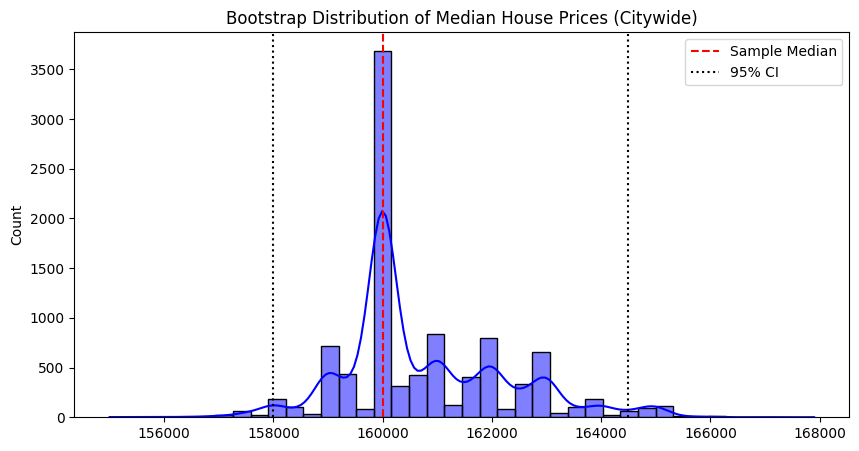

In [9]:
#Plot Bootstrap distribution for median (citywide)
plt.figure(figsize=(10,5))
sns.histplot(boot_median,bins=40,kde=True,color="blue")
plt.axvline(median_city,color="red",linestyle="--",label="Sample Median")
plt.axvline(ci_low_median,color="black",linestyle=":",label="95% CI")
plt.axvline(ci_high_median,color="black",linestyle=":")
plt.title("Bootstrap Distribution of Median House Prices (Citywide)")
plt.legend()
plt.show()

# Adding Parametric CI calculations alongside Bootstrap ones.

<h4>Parametric CI for the Mean

In [10]:
from scipy import stats

def parametric_ci_mean(data, ci=95):
    """Parametric CI for the mean using Normal approximation."""
    mean = np.mean(data)
    se = stats.sem(data)  # standard error of the mean
    alpha = 1 - ci/100
    lower, upper = stats.norm.interval(1 - alpha, loc=mean, scale=se)
    return mean, (lower, upper)


<h4>Parametric CI for the Median

In [11]:
def parametric_ci_median(data, ci=95):
    """Parametric (binomial) CI for the median."""
    data_sorted = np.sort(data)
    n = len(data)
    alpha = 1 - ci/100
    z = stats.norm.ppf(1 - alpha/2)

    # Index bounds
    lower_idx = int(max(0, np.floor(n/2 - z*np.sqrt(n)/2)))
    upper_idx = int(min(n-1, np.ceil(n/2 + z*np.sqrt(n)/2)))

    return np.median(data), (data_sorted[lower_idx], data_sorted[upper_idx])


<h4>Parametric CI for the 75th Percentile

In [12]:
def parametric_ci_quantile(data, q=0.75, ci=95):
    """Parametric CI for a quantile (using binomial order statistics)."""
    data_sorted = np.sort(data)
    n = len(data)
    alpha = 1 - ci/100

    # Expected rank of quantile
    k = int(np.floor(q * n))

    # Binomial bounds
    lower = stats.binom.ppf(alpha/2, n, q)
    upper = stats.binom.isf(alpha/2, n, q)

    lower_idx = int(max(0, lower - 1))
    upper_idx = int(min(n-1, upper - 1))

    return np.percentile(data, q*100), (data_sorted[lower_idx], data_sorted[upper_idx])


<h4>Applying to Citywide Prices

In [13]:
prices = df["SalePrice"].values

# Mean
mean, (ci_low_mean, ci_high_mean) = parametric_ci_mean(prices)
print(f"Parametric CI (Mean): {ci_low_mean:,.0f} – {ci_high_mean:,.0f}")

# Median
median, (ci_low_median_p, ci_high_median_p) = parametric_ci_median(prices)
print(f"Parametric CI (Median): {ci_low_median_p:,.0f} – {ci_high_median_p:,.0f}")

# 75th percentile
q75, (ci_low_q75_p, ci_high_q75_p) = parametric_ci_quantile(prices, q=0.75)
print(f"Parametric CI (75th Percentile): {ci_low_q75_p:,.0f} – {ci_high_q75_p:,.0f}")


Parametric CI (Mean): 177,903 – 183,689
Parametric CI (Median): 158,000 – 164,700
Parametric CI (75th Percentile): 209,000 – 218,000


In [15]:
from scipy import stats
#Percentile Bootstrap CI
def bootstrap_percentile_ci(data,func=np.median,n_boot=10000,ci=95):
  n=len(data)
  stats_list=[]
  for _ in range(n_boot):
    sample=np.random.choice(data,size=n,replace=True)
    stats_list.append(func(sample))
  stats_arr=np.array(stats_list)
  lower=np.percentile(stats_arr,(100-ci)/2)
  upper=np.percentile(stats_arr,100-(100-ci)/2)
  return func(data),(lower,upper),stats_arr

#Bias-Corrected & Accelarated (BCa) Bootstrap CI
def bootstrap_bca_ci(data,func=np.median,n_boot=10000,ci=95):
  n=len(data)
  obs_stat=func(data)
  boot_stats=[]
  for _ in range(n_boot):
    sample=np.random.choice(data,size=n,replace=True)
    boot_stats.append(func(sample))
  boot_stats=np.array(boot_stats)

  #Proportion of bootstrap estimates less than observed
  z0=stats.norm.ppf((boot_stats < obs_stat).mean())

  #Jackknife for acceleration
  jackknife=[]
  for i in range(n):
    jackknife_sample=np.delete(data,i)
    jackknife.append(func(jackknife_sample))
  jackknife=np.array(jackknife_sample)
  jack_mean=jackknife.mean()
  num=np.sum((jack_mean - jackknife)**3)
  den=6.0*(np.sum((jack_mean - jackknife)**2))**1.5
  acc=num/den if den !=0 else 0

  alpha=(100-ci)/200
  zs=[z0+(z0 + stats.norm.ppf(alpha))/(1 - acc*(z0 + stats.norm.ppf(alpha))),
      z0+(z0 + stats.norm.ppf(1-alpha))/(1-acc*(z0+stats.norm.ppf(1-alpha)))]
  pct=stats.norm.cdf(zs)*100
  lower,upper=np.percentile(boot_stats,pct)
  return obs_stat,(lower,upper),boot_stats

#Apply to Ames House Prices

In [16]:
prices=df["SalePrice"].values

#Median
median_val,(low_p,high_p),boot_median=bootstrap_percentile_ci(prices,np.median)
median_val,(low_bca,high_bca), _=bootstrap_bca_ci(prices,np.median)
print(f"Median Price={median_val:,.0f}")
print(f"Bootstrap Percentile CI:{low_p:,.0f}-{high_p:,.0f}")
print(f"Bootstrap BCa CI:{low_bca:,.0f}-{high_bca:,.0f}")

#75th Percentile
q75_val,(low_p_q75,high_p_q75),boot_q75=bootstrap_percentile_ci(prices,lambda x: np.percentile(x,75))
q75_val,(low_bca_q75,high_bca_q75),_=bootstrap_bca_ci(prices,lambda x:np.percentile(x,75))
print(f"75th Percentile = {q75_val:,.0f}")
print(f"Bootstrap Percentile CI:{low_p_q75:,.0f}-{high_p_q75:,.0f}")
print(f"Bootstap BCa CI:{low_bca_q75:,.0f}-{high_bca_q75:,.0f}")

Median Price=160,000
Bootstrap Percentile CI:158,000-164,500
Bootstrap BCa CI:156,102-161,000
75th Percentile = 213,500
Bootstrap Percentile CI:209,000-218,000
Bootstap BCa CI:208,975-217,500


#Parametric CIs for Comparison

In [17]:
#Parametric Mean CI
mean=np.mean(prices)
se=stats.sem(prices)
param_ci_mean=stats.norm.interval(0.95,loc=mean,scale=se)

print(f"Parametric Mean CI:{param_ci_mean[0]:,.0f}-{param_ci_mean[1]:,.0f}")

Parametric Mean CI:177,903-183,689
